In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import sklearn
import imblearn
import matplotlib.pyplot as plt
import time
import sklearn.metrics as m
import warnings
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
warnings.filterwarnings('ignore')

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

In [2]:
df1=pd.read_csv("./archive/Friday-WorkingHours-Afternoon-DDos.csv")
df2=pd.read_csv("./archive/Friday-WorkingHours-Afternoon-PortScan.csv")
df3=pd.read_csv("./archive/Friday-WorkingHours-Morning.csv")
df4=pd.read_csv("./archive/Monday-WorkingHours.csv")
df5=pd.read_csv("./archive/Thursday-WorkingHours-Afternoon-Infilteration.csv")
df6=pd.read_csv("./archive/Thursday-WorkingHours-Morning-WebAttacks.csv")
df7=pd.read_csv("./archive/Tuesday-WorkingHours.csv")
df8=pd.read_csv("./archive/Wednesday-workingHours.csv")

In [3]:
print(df1[' Label'].value_counts())
print()
print(df2[' Label'].value_counts())
print()
print(df3[' Label'].value_counts())
print()
print(df4[' Label'].value_counts())
print()
print(df5[' Label'].value_counts())
print()
print(df6[' Label'].value_counts())
print()
print(df7[' Label'].value_counts())
print()
print(df8[' Label'].value_counts())


DDoS      128027
BENIGN     97718
Name:  Label, dtype: int64

PortScan    158930
BENIGN      127537
Name:  Label, dtype: int64

BENIGN    189067
Bot         1966
Name:  Label, dtype: int64

BENIGN    529918
Name:  Label, dtype: int64

BENIGN          288566
Infiltration        36
Name:  Label, dtype: int64

BENIGN                        168186
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Name:  Label, dtype: int64

BENIGN         432074
FTP-Patator      7938
SSH-Patator      5897
Name:  Label, dtype: int64

BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name:  Label, dtype: int64


In [4]:
one_variable_list = []
for i in df5.columns:
    if df5[i].value_counts().nunique() < 2:
        one_variable_list.append(i)
df5.drop(one_variable_list,axis=1,inplace=True)
df5.columns =  df5.columns.str.strip()

In [5]:
corr_matrix = df5.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Drop features 
df5 =  df5.drop(to_drop, axis=1)
df5.shape

(288602, 29)

In [6]:
df5 = df5[~df5.isin([np.nan, np.inf, -np.inf]).any(1)]

df5.loc[df5['Label']=='BENIGN','Label']=0
df5.loc[df5['Label']=='Infiltration','Label']=1

In [7]:
x = df5.drop(["Label"],axis=1)
y = df5["Label"]

In [8]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Label, dtype: object

In [9]:
df5['Label'].value_counts()

0    288359
1        36
Name: Label, dtype: int64

In [10]:
x_train_ori = np.array(x)
y_train_ori=np.array(y.astype(int))

print(x_train_ori.shape)
print(y_train_ori.shape)

(288395, 28)
(288395,)


In [11]:
TIME_STEPS = 32

x_train_reshaped = []
y_train_reshaped = []

for i in range(y_train_ori.shape[0] - TIME_STEPS + 1):
    x_train_reshaped.append(x_train_ori[i : i + TIME_STEPS])
    y_train_reshaped.append(y_train_ori[i : i + TIME_STEPS])

x_train_reshaped = np.array(x_train_reshaped)
y_train_reshaped = np.array(y_train_reshaped)

print(x_train_reshaped.shape)
print(y_train_reshaped.shape)

(288364, 32, 28)
(288364, 32)


In [12]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train_reshaped, y_train_reshaped, test_size=0.15
)

In [13]:
print(
    f"y_train - True: {np.count_nonzero(y_train)} | "
    + f"False:{ len(y_train) - np.count_nonzero(y_train)}"
)
print(
    f"y_val - True: {np.count_nonzero(y_val)} | "
    + f"False:{ len(y_val) - np.count_nonzero(y_val)}"
)

y_train - True: 1002 | False:244107
y_val - True: 150 | False:43105


In [14]:
input_shape = (None, TIME_STEPS, 28) 

In [15]:
import tensorflow as tf

bi_lstm_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                32,
            )
        ),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(TIME_STEPS, activation="sigmoid"),
    ]
)

bi_lstm_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
    ],
)


bi_lstm_model.build(input_shape)
bi_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  47616     
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  41216     
_________________________________________________________________
dense (Dense)                multiple                  8320      
_________________________________________________________________
dense_1 (Dense)              multiple                  8256      
_________________________________________________________________
dense_2 (Dense)              multiple                  2080      
Total params: 107,488
Trainable params: 107,488
Non-trainable params: 0
_________________________________________________________________


In [16]:
import datetime

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"./model/bi_lstm_model_{TIME_STEPS}_{TIME_STEPS}.h5",
    monitor="loss",
    verbose=1,
    save_best_only=True,
    mode="auto",
    period=1,
)

log_dir = f"./logs/lstm{TIME_STEPS}seq/" + datetime.datetime.now().strftime(
    "%Y%m%d-%H%M%S"
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1, profile_batch=0
)

history = bi_lstm_model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, tensorboard_callback],
)

- precision: 0.2500 - recall: 9.9800e-04 - auc: 0.7886
Epoch 00012: loss improved from 0.00091 to 0.00085, saving model to ./model/bi_lstm_model_32_32.h5
3830/3830 [==============================] - 31s 8ms/step - loss: 8.4711e-04 - binary_accuracy: 0.9999 - precision: 0.2500 - recall: 9.9800e-04 - auc: 0.7886 - val_loss: 7.8632e-04 - val_binary_accuracy: 0.9999 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7623
Epoch 13/50
3825/3830 [============================>.] - ETA: 0s - loss: 8.0385e-04 - binary_accuracy: 0.9999 - precision: 0.5000 - recall: 0.0030 - auc: 0.8187
Epoch 00013: loss improved from 0.00085 to 0.00080, saving model to ./model/bi_lstm_model_32_32.h5
3830/3830 [==============================] - 31s 8ms/step - loss: 8.0292e-04 - binary_accuracy: 0.9999 - precision: 0.5000 - recall: 0.0030 - auc: 0.8187 - val_loss: 7.6148e-04 - val_binary_accuracy: 0.9999 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7789
Epoch 14/50
3824/3830 [===

In [17]:
def plot_metrics(history):
    metrics = ["loss", "auc", "precision", "recall"]

    plt.figure(figsize=(20, 10))

    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], label="Train")
        plt.plot(
            history.epoch, history.history["val_" + metric], linestyle="--", label="Val"
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "auc":
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])

    plt.legend()
    plt.show()

In [18]:
eval_result_training = bi_lstm_model.evaluate(x_train_reshaped, y_train_reshaped)
print(eval_result_training)

9012/9012 [==============================] - 36s 4ms/step - loss: 3.7195e-04 - binary_accuracy: 0.9999 - precision: 0.7713 - recall: 0.1962 - auc: 0.9452
[0.0003719544329214841, 0.9998924136161804, 0.7713310718536377, 0.1961805522441864, 0.945172905921936]


In [19]:
y_train_predicted = bi_lstm_model.predict(x_train_reshaped)

In [20]:
print("Grouping same packet")
y_train_predicted_grouped = {}
for i in range(y_train_predicted.shape[0]):
    for j in range(y_train_predicted.shape[1]):
        if i + j not in y_train_predicted_grouped:
            y_train_predicted_grouped[i + j] = []
        y_train_predicted_grouped[i + j].append(y_train_predicted[i][j])
    print(
        f"{i}/{y_train_predicted.shape[0]} | {i/y_train_predicted.shape[0]*100.0:3.0f} %     ",
        end="\r",
    )
print("")

Grouping same packet
288363/288364 | 100 %     


In [21]:
y_train_predicted_mean = []
# y_train_predicted_any = []

# treshold = 0.5

for i in range(len(y_train_predicted_grouped)):
    y_train_predicted_mean.append(np.mean(y_train_predicted_grouped[i]))
    #     y_train_predicted_any.append(
    #         1.0
    #         if np.any(np.where(np.array(y_train_predicted_grouped[i]) > treshold))
    #         else 0.0
    #     )
    print(
        f"{i}/{y_train_predicted.shape[0]} | {i/y_train_predicted.shape[0]*100.0:3.0f} %     ",
        end="\r",
    )
print("")

y_train_predicted_mean = np.array(y_train_predicted_mean)

288394/288364 | 100 %     


In [22]:
import sklearn


def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100 * fp, 100 * tp, label=name, linewidth=2, **kwargs)
    plt.xlabel("False positives [%]")
    plt.ylabel("True positives [%]")
    plt.xlim([-0.5, 20])
    plt.ylim([80, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect("equal")

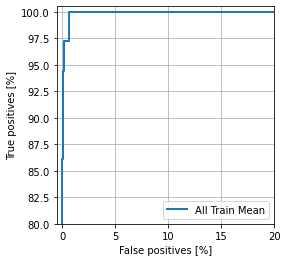

In [23]:
plot_roc("All Train Mean", y_train_ori, y_train_predicted_mean)
# plot_roc(
#     "All Train Any", y_train_ori, y_train_predicted_any
# )

plt.legend(loc="lower right")
plt.show()

In [24]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    acc = accuracy_score(labels, predictions > p)
    prec = precision_score(labels, predictions > p)
    recall = recall_score(labels, predictions > p)
    f1 = f1_score(labels, predictions > p)
    auc = roc_auc_score(labels, predictions)

    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix @{:.2f}".format(p))
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

    print(
        f"Accuracy: {acc}\nPrecision: {prec}\nRecall: {recall}\nF1: {f1}\nAUC: {auc}\n"
    )

    print("Legitimate Transactions Detected (True Negatives): ", cm[0][0])
    print("Legitimate Transactions Incorrectly Detected (False Positives): ", cm[0][1])
    print("Fraudulent Transactions Missed (False Negatives): ", cm[1][0])
    print("Fraudulent Transactions Detected (True Positives): ", cm[1][1])
    print("Total Fraudulent Transactions: ", np.sum(cm[1]))

Accuracy: 0.9998751712061582
Precision: 0.0
Recall: 0.0
F1: 0.0
AUC: 0.9997306598140975

Legitimate Transactions Detected (True Negatives):  288359
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  36
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  36


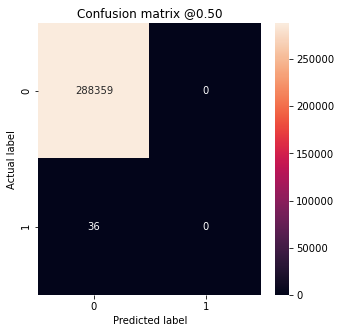

In [25]:
plot_cm(y_train_ori[: len(y_train_predicted_mean)], y_train_predicted_mean, p=0.5)